In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['koko-newdata', 'iwildcam-2019-fgvc6']


In [2]:
import os
import json

import numpy as np
import pandas as pd
import keras
from keras import layers
from keras.applications import DenseNet121
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

Using TensorFlow backend.


In [3]:
x_train = np.load('../input/koko-newdata/X_newtrain.npy')
x_test = np.load('../input/koko-newdata/X_newtest.npy')
y_train = np.load('../input/koko-newdata/y_newtrain.npy')

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (98150, 32, 32, 3)
98150 train samples
9815 test samples


In [4]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.
x_test /= 255.

In [5]:
class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []

    def on_epoch_end(self, epoch, logs={}):
        X_val, y_val = self.validation_data[:2]
        y_pred = self.model.predict(X_val)

        y_pred_cat = keras.utils.to_categorical(
            y_pred.argmax(axis=1),
            num_classes=14
        )

        _val_f1 = f1_score(y_val, y_pred_cat, average='macro')
        _val_recall = recall_score(y_val, y_pred_cat, average='macro')
        _val_precision = precision_score(y_val, y_pred_cat, average='macro')

        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)

        print((f"val_f1: {_val_f1:.4f}"
               f" — val_precision: {_val_precision:.4f}"
               f" — val_recall: {_val_recall:.4f}"))

        return

f1_metrics = Metrics()

In [6]:
def create_Model():
    classifier=Sequential()
    classifier.add(Conv2D(32, kernel_size=(3, 3),padding='same',input_shape=x_train.shape[1:],activation='relu'))
    #classifier.add(Conv2D(64, (3, 3), activation='relu'))
    #classifier.add(ZeroPadding2D(padding=(1,1)))
    #classifier.add(BatchNormalization())
    #classifier.add(PReLU())
    classifier.add(Conv2D(32, (3, 3)))
    classifier.add(Activation('relu'))
    classifier.add(MaxPooling2D(pool_size=(2, 2)))
    classifier.add(Dropout(0.25))

    classifier.add(Conv2D(64, (3, 3), padding='same'))
    classifier.add(Activation('relu'))
    classifier.add(Conv2D(64, (3, 3)))
    classifier.add(Activation('relu'))
    classifier.add(MaxPooling2D(pool_size=(2, 2)))
    classifier.add(Dropout(0.25))

    classifier.add(Flatten())
    classifier.add(Dense(512))
    classifier.add(Activation('relu'))
    classifier.add(Dropout(0.5))
    classifier.add(Dense(14))
    classifier.add(Activation('softmax'))
    return classifier
model=create_Model()
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)    

In [7]:
checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor='val_acc', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)
# 64,7,0.1
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=32,
    epochs=3,
    callbacks=[checkpoint, f1_metrics],
    validation_split=0.05
)

Instructions for updating:
Use tf.cast instead.
Train on 93242 samples, validate on 4908 samples
Epoch 1/3
93242/93242 [==============================] - 334s 4ms/step - loss: 0.7731 - acc: 0.7628 - val_loss: 0.5828 - val_acc: 0.8117

Epoch 00001: val_acc improved from -inf to 0.81174, saving model to model.h5
val_f1: 0.4167 — val_precision: 0.5390 — val_recall: 0.3985
Epoch 2/3
   32/93242 [..............................] - ETA: 5:35 - loss: 0.6014 - acc: 0.7812

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


93242/93242 [==============================] - 332s 4ms/step - loss: 0.5744 - acc: 0.8164 - val_loss: 0.5005 - val_acc: 0.8382

Epoch 00002: val_acc improved from 0.81174 to 0.83822, saving model to model.h5
val_f1: 0.5118 — val_precision: 0.6032 — val_recall: 0.4813
Epoch 3/3
93242/93242 [==============================] - 333s 4ms/step - loss: 0.5092 - acc: 0.8347 - val_loss: 0.4619 - val_acc: 0.8509

Epoch 00003: val_acc improved from 0.83822 to 0.85086, saving model to model.h5
val_f1: 0.5925 — val_precision: 0.7100 — val_recall: 0.5570


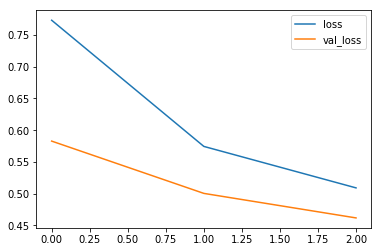

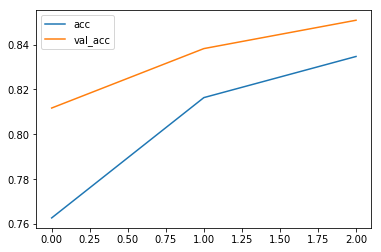

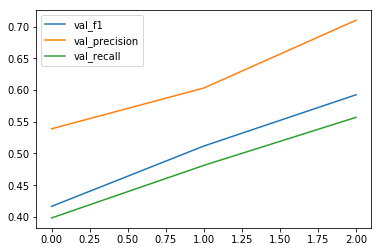

In [25]:
with open('history.json', 'w') as f:
    json.dump(history.history, f)

history_df = pd.DataFrame(history.history)
history_df['val_f1'] = f1_metrics.val_f1s
history_df['val_precision'] = f1_metrics.val_precisions
history_df['val_recall'] = f1_metrics.val_recalls
history_df[['loss', 'val_loss']].plot()
history_df[['acc', 'val_acc']].plot()
history_df[['val_f1', 'val_precision', 'val_recall']].plot()

In [27]:
model.load_weights('model.h5')
y_train=np.load('../input/koko-newdata/y_coltrain.npy')
y_predict = model.predict(x_train)
y_predict=y_predict.argmax(axis=1)

In [28]:
y_train

array([18,  0,  0, ...,  0,  0, 11])

In [29]:
y_predict

array([6, 0, 0, ..., 0, 0, 6])

In [30]:
from sklearn.metrics import confusion_matrix,accuracy_score,f1_score 
from sklearn.metrics import recall_score,precision_score,classification_report 
print('Accuracy:', accuracy_score(y_train, y_checktrain))
print('F1 score:', f1_score(y_train, y_checktrain,average='weighted'))
print('Recall:', recall_score(y_train, y_checktrain,
                              average='weighted'))
print('Precision:', precision_score(y_train, y_checktrain,
                                    average='weighted'))
print('\n clasification report:\n', classification_report(y_train, y_checktrain))
print('\n confussion matrix:\n',confusion_matrix(y_train, y_checktrain))

Accuracy: 0.6779317371370351
F1 score: 0.6728471667618514
Recall: 0.6779317371370351
Precision: 0.6693551815655341

 clasification report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.96     65650
           1       0.84      0.84      0.84      3093
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00      1660
           4       0.01      0.03      0.02      1106
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.03      0.00      0.00      3529
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00       529
          11       0.03      0.01      0.02      3577
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00      4286
          14       0.00      0.00      0.00      

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning


 confussion matrix:
 [[63855   257   170   117   208    18   247   200     6    53    44    84
    391     0     0     0     0     0     0     0]
 [  421  2602     0    12     1     2    43     3     0     1     0     2
      5     1     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0]
 [  216     5  1181     0   104     0    16     0     0     6    38    91
      3     0     0     0     0     0     0     0]
 [   90     1     0   791    33     7    10   106     1    19     0     0
     48     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0    

In [33]:
y_test=np.load('../input/koko-newdata/y_coltest.npy')
y_predict_test = model.predict(x_test)
y_predict_test=y_predict_test.argmax(axis=1)

In [34]:
from sklearn.metrics import confusion_matrix,accuracy_score,f1_score 
from sklearn.metrics import recall_score,precision_score,classification_report 
print('Accuracy:', accuracy_score(y_test, y_predict_test))
print('F1 score:', f1_score(y_test, y_predict_test,average='weighted'))
print('Recall:', recall_score(y_test, y_predict_test,
                              average='weighted'))
print('Precision:', precision_score(y_test, y_predict_test,
                                    average='weighted'))
print('\n clasification report:\n', classification_report(y_test, y_predict_test))
print('\n confussion matrix:\n',confusion_matrix(y_test, y_predict_test))

Accuracy: 0.6772287315333673
F1 score: 0.6720626736258773
Recall: 0.6772287315333673
Precision: 0.6726930146435672

 clasification report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96      6566
           1       0.80      0.80      0.80       343
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00       185
           4       0.01      0.02      0.01       104
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.17      0.01      0.01       345
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00        58
          11       0.04      0.02      0.03       370
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00       421
          14       0.00      0.00      0.00      

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning

In [41]:
def hoeffding_bound(Ein,N,M,confidence):
   delta=1-confidence
   A=np.log(2*M/delta)
   bond=np.sqrt(A/(2*N))
   limit=Ein-bond
   return limit

In [42]:
limit=hoeffding_bound(0.6728471667618514,98150,1,0.95)
print(limit)

0.6685121869234605
